# **Tarefa \#3**:  Aprendizado de Máquina e Reconhecimento de Padrões MC886/MO444
Instituto de Computação (IC/UNICAMP), 2o Semestre, 2023

Profa. Sandra Avila, 2023s2



In [ ]:
# TODO: RA & Name
print('RA1: 199798 ' + 'João Victor A. Batista')
print('RA2: 185448 ' + 'Paulo B. Pacitti')
print('RA3: 170776 ' + 'João Vitor Lopes Capi')

RA1: 199798 João Victor A. Batista
RA2: 185448 Paulo B. Pacitti
RA3: 170776 João Vitor Lopes Capi


In [8]:
import gdown

file_id = "11YjBopueI65xYYne5ulV6IJ_dELPMrIt"
output = "dataset.npy"

gdown.download(
    url=f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}",
    output=output
)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?export=download&confirm=pbef&id=11YjBopueI65xYYne5ulV6IJ_dELPMrIt 



## Objetivo

Explore as redes neurais e desenvolva o melhor modelo possível para o problema, evitando o *overfitting*. Em particular, construir um modelo para classificar imagens utilizando o [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) com precisão.

Nessa atividade, **não é permitido o uso de frameworks de redes neurais** (exemplo, Pytorch, Tensorflow, Keras), com exceção de funções básicas como os Dataloaders que já estão especificados no código. Você deve implementar os métodos necessários usando [NumPy](https://numpy.org/doc/1.23/user/index.html#user). De mesmo modo, você pode utilizar ``scikit-learn`` (ou bibliotecas similares) para computar métodos de avaliação, e todas as bibliotecas de visualização também são permitidas.

Criamos um teste de sanidade para todos os métodos que você precisa implementar, para que você possa verificar se o comportamento geral do seu algoritmo está correto. Porém, não garante que sua implementação esteja correta. Depurar modelos de redes neurais é uma tarefa trabalhosa.

## Dataset

O conjunto de dados CIFAR-10 é um conjunto de dados amplamente utilizado para tarefas de classificação de imagens. Ele consiste em um conjunto de 60.000 imagens coloridas de baixa resolução (32x32 pixels) divididas em 10 classes diferentes. Cada classe contém 6.000 imagens, tornando o conjunto de dados bem equilibrado. As 10 classes representam objetos comuns que podem ser encontrados no mundo real. Aqui estão as 10 classes do CIFAR-10:


|ID      | Classe   |
|--------|-----------
|   0    | Avião    |
|   1    | Carro    |
|   2    | Ave      |
|   3    | Gato     |
|   4    | Cervo    |
|   5    | Cachorro |
|   6    | Sapo     |
|   7    | Cavalo   |
|   8    | Navio    |
|   9    | Caminhão |


Neste trabalho, nós usaremos uma versão modificada deste conjunto. Você terá 30 mil exemplos para treino, e 10 mil exemplos para validação e teste.


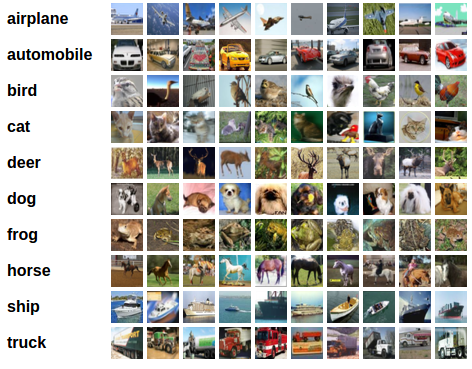

**Informações do conjunto de dados:**

- Você deve respeitar a seguinte divisão treinamento/validação/teste. Evite *overfitting*.
- Os dados estão disponíveis no Google Classroom ou em https://drive.google.com/file/d/1Zqs_fM4h-Wy6f2BteddPPOPQMjKaDDtA/view?usp=drive_link
- Você deve avaliar os modelos usando **balanced accuracy** (acurácia balanceada).

## Prazo
Terça-feira, 10 de Outubro, 23h59.

Política de penalidades para envio tardio: Você não é incentivada(o) a enviar sua tarefa após o prazo. Porém, caso o faça, sua nota será penalizada da seguinte forma:
- 11 de Outubro 23h59: nota * 0,75
- 12 de Outubro 23h59: nota * 0,5
- 13 de Outubro 23h59: nota * 0,25

## Envio

No Google Classroom, envie seu Jupyter Notebook.

**Esta atividade NÃO é individual, deve ser realizada em duplas (grupo de duas pessoas).**

In [2]:
from typing import List
from abc import ABC,abstractmethod
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
# prepare os dados para serem usados pelo Pytorch Dataloader

class CIFAR10(Dataset):
    def __init__(self, x, y=None, transform=None):
        self._x = x
        self._y = y#.squeeze() if y is not None else None
        self._transform = transform

    def __len__(self):
        return len(self._x)

    def __getitem__(self, idx):
        image = self._x[idx]
        if self._transform is not None:
            image = self._transform(image)

        image = image.flatten()
        if self._y is None:
            return image

        # one hot encoding
        label = [0] * 10
        label[self._y[idx]] = 1
        return image, torch.Tensor(label)

In [4]:
# um exemplo de uma função de normalização, mas você poderá implementar outras
def normalize(X):
    return (X - X.mean())/(X.std() + 1e-8)

#### Carregando os dados

In [9]:
# defina o caminho do conjunto de dados corretamente
dataset_path = 'data/dataset.npy'
dataset = np.load(dataset_path, allow_pickle=True).item()

x_train, y_train = dataset['train_images'], dataset['train_labels']
x_val, y_val = dataset['val_images'], dataset['val_labels']
x_test, y_test = dataset['test_images'], dataset['test_labels']
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
train_set = CIFAR10(x_train, y_train, transform=normalize)
val_set = CIFAR10(x_val, y_val, transform=normalize)
test_set = CIFAR10(x_test, y_test, transform=normalize)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

## Tarefas de implementação

#### Funções de ativação e perda

As funções de ativação são componentes essenciais de uma rede neural. Portanto, explore diferentes funções de ativação em seus modelos e analise as diferenças nos resultados. Além disso, implemente a entropia cruzada e use-a como sua função de perda, já que você está trabalhando em um problema de classificação multiclasse.

Implementar, no local indicado, as seguintes funções:

* Softmax (seu gradiente já está implementado);
* Cross-Entropy (seu gradiente já está implementado);
* Uma função de ativação de sua preferência, bem como seu gradiente. Deve ser uma subclasse de ``BaseFunction``. (Para referência, leia esta [postagem do blog](https://dwaithe.github.io/blog_20170508.html).)

**Dica**:
Utilize $ϵ=1e-8$ sempre que necessário.

In [11]:
class BaseFunction(ABC):
    @abstractmethod
    def __call__(self, X):
        pass

    @abstractmethod
    def grad(self, X):
        pass


class ReLU(BaseFunction):
    def __call__(self, X):
        return np.maximum(np.zeros_like(X), X)

    def grad(self, X):
        return np.where(X >= 0, 1, 0)

#######################################################
# TODO: implemente aqui outra função de ativação

# Exemplo:

class LeakyReLU(BaseFunction):
    def __call__(self, X):
        return np.maximum(0.01 * X, X)

    def grad(self, X):
        return np.where(X >= 0, 1, 0.01)

#######################################################

class Softmax(BaseFunction):
    # https://stackoverflow.com/questions/43401593/softmax-of-a-large-number-errors-out
    def __call__(self, X):
        """
        Argumentos:
        X: (np.array) dados de entrada

        Return:
        Saída Softmax
        """
        unique_values = dict(axis=1, keepdims=True)

        # subtracts the maximum value of each row of the input array, to prevent overflow of np.exp
        X_rel = X - X.max(**unique_values)

        exp_X_rel = np.exp(X_rel)
        return exp_X_rel / np.sum(exp_X_rel, axis=1, keepdims=True)

    def grad(self, X):
        return 1 # descarte esse gradientes


class CrossEntropy(BaseFunction):
    def __call__(self, Y, Y_pred):
        """
        Argumentos:
        Y: (np.array) labels verdadeiros
        Y_pred: (np.array) labels preditos

        Retorna:
        Saída da Entropia Cruzada
        """
        ##################################
        # TODO: implemente aqui a entropia cruzada
        # use epsilon=1e-8
        ##################################
        epsilon = 1e-8
        return -np.sum(Y * np.log(Y_pred + epsilon)) / Y.shape[0]

    def grad(self, Y, Y_pred):
        return Y_pred - Y # gradiente em relação à entrada do Softmax

**Teste de sanidade**

In [12]:
######## checando a Softmax ########

s = Softmax()
x = np.array([[0,0],
              [1,2],
              [-3,2]])

expected_softmax = np.array([[0.5       , 0.5       ],
                             [0.26894142, 0.73105858],
                             [0.00669285, 0.99330715]])
result_softmax = s(x)
assert (abs(result_softmax - expected_softmax) < 1e-8).all(), f"O resultado esperado da softmax é {expected_softmax}, mas retorna {result_softmax}"

In [13]:
######## checando a CrossEntropy ########

Y = np.array([[0, 1, 1],
              [1, 0, 0]])

Y_pred = np.array([[0, 1, 1],
                   [0.7, 0, 0.3],])


expected_ce = 0.1783374548265092
cross_entropy = CrossEntropy()
ce_result = cross_entropy(Y, Y_pred)
assert abs(ce_result - expected_ce) < 1e-8, f"O resultado esperado pela entropia cruzada é {expected_ce}, mas retorna {ce_result}"

expected_grad = np.array([[ 0. ,  0. ,  0. ],
                          [-0.3,  0. ,  0.3]])
grad = cross_entropy.grad(Y, Y_pred)
assert (abs(grad - expected_grad) < 1e-8).all(), f"O resultado esperado pelo gradiente da entropia cruzaada é {expected_grad}, mas retorna {grad}"

#### Modelo

Em uma rede neural, as previsões são feitas usando um algoritmo denominado Feedforward, também conhecido como forward step. Portanto, você deve implementar este método para fazer previsões usando seus modelos.

Além disso, é fundamental inicializar os pesos da rede adequadamente para garantir um modelo de melhor desempenho. Caso contrário, pode dar origem a um problema de Gradiente Desaparecido ou Gradiente Explosivo. Então, experimente diferentes técnicas de inicialização de pesos e veja o que acontece. Já implementamos o aleatório e [He et al.](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) Inicialização normal para você :D

Implementar, no local indicado, os seguintes métodos:

* Feedforward, também conhecido como passo adiante;
* Um método de inicialização de peso de sua escolha. (Para referência, leia esta [postagem do blog](https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/).)

PS. Observe que as matrizes de peso $W$ na rede são construídas de modo que $w^{l}_{i,j}$ seja o peso que conecta o i-ésimo neurônio na l-ésima camada ao j-ésimo neurônio na camada seguinte, conforme ilustrado abaixo.



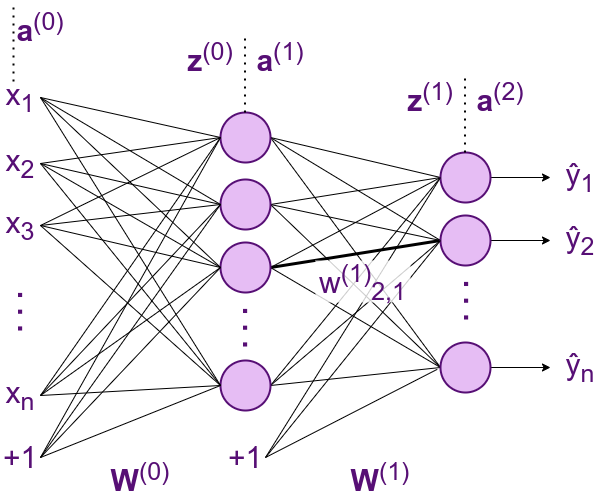


**Feed Forward**:

$a^{(l)} = f_{(l-1)}(z^{(l-1)})$

In [14]:
class Model:
    def __init__(self, layers_dims: List[int],
                 activation_funcs: List[BaseFunction],
                 initialization_method: str = "random"):
        """
        Argumentos:
        layers_dims: (list) lista com o tamanho de cada camada
        activation_funcs: (list) lista com as funções de ativação
        initialization_method: (str) indica como inicializar os parâmetros

        Exemplo:

        # Um modelo de arquitetura com camadas 2 x 1 x 2 e 2 ReLU como funções de ativação
        >>> m = Model([2, 1, 2], [ReLU(), ReLU()])
        """

        assert all([isinstance(d, int) for d in layers_dims]), \
        "É esperado uma lista de int como o parâmetro ``layers_dims"

        assert all([isinstance(a, BaseFunction) for a in activation_funcs]), \
        "É esperado uma lista de BaseFunction como o parâmetro ``activation_funcs´´"

        self.layers_dims = layers_dims
        self.activation_funcs = activation_funcs
        self.weights, self.bias = self.initialize_model(initialization_method)


    def __len__(self):
        return len(self.weights)


    def initialize_model(self, method="random"):
        """
        Argumentos:
        layers_dims: (list)  lista com o tamanho de cada camada
        method: (str) indica como inicializar os parâmetros

        Retorna: uma lista de matrizes (np.array) de pesos e
        uma lista de matrizes (np.array) como biases.
        """

        weights = []
        bias = []
        n_layers = len(self.layers_dims)
        for l in range(0, n_layers-1):
            # o peso w_i,j  conecta o i-th neurônio na camada atual para
            # o j-th neurônio na próxima camada
            W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1])
            b = np.random.randn(1, self.layers_dims[l + 1])

            # He et al. Inicialização Normal
            if method.lower() == 'he':
                W = W * np.sqrt(2/self.layers_dims[l])
                b = b * np.sqrt(2/self.layers_dims[l])
            # TODO: implemente outro método de inicialização
            if method.lower() == 'xavier':
                W = W * np.sqrt(1/np.mean([self.layers_dims[l], self.layers_dims[l+1]]))
                b = b * np.sqrt(1/np.mean([self.layers_dims[l], self.layers_dims[l+1]]))

            weights.append(W.astype(np.float64))
            bias.append(b.astype(np.float64))

        return weights, bias


    def forward(self, X):
        """
        Argumentos:
        X: (np.array) dados de entrada

        Retorno:
        Predições para os dados de entrada (np.array)
        """
        activation = X
        self.activations = [X]
        self.Z_list = []
        #############################################################################
        # TODO: implemente aqui o forward step.
        #
        # Mais algumas instruções:
        # Note que os pesos, bias e funções de ativações são variáveis de classe,
        # então você pode acessá-los através do ``self``.
        #
        # Você deve armazenar a entrada Z de cada função de ativação em ``Z_list``,
        # e a saída das funções de ativação em ``ativações``. Esses
        # informações serão importantes quando você implementar a passagem para trás.
        #############################################################################
        for layer in range(len(self.weights)):
            z = np.dot(activation, self.weights[layer]) + self.bias[layer]
            self.Z_list.append(z)
            activation = self.activation_funcs[layer](z)
            self.activations.append(activation)
        return self.activations[-1]

**Teste de sanidade**

In [15]:
######## Checando Forward pass ########

# Arquitetura: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), ReLU()])

X = np.array([[0 ,1],
              [-1,0]])

W1 = np.array([[2],
               [1]])
b1 = np.array([[1]])
W2 = np.array([[2, 3]])
b2 = np.array([[1, -1]])

m.weights = [W1, W2]
m.bias = [b1, b2]

expected_prediction = np.array([[5,5],
                                [1,0]])

expected_Z_list = [np.array([[2],
                             [-1]]),
                   np.array([[5,5],
                             [1,-1]]),]

expected_activations = [X,
                        np.array([[2],
                                  [0]]),
                        expected_prediction]

#forward pass
prediction = m.forward(X)

for l, (expected_z, z) in enumerate(zip(expected_Z_list, m.Z_list)):
    assert ((z - expected_z) < 1e-8).all(), \
    f"Forward pass {l}: resultado esperado da Z list {expected_z}, mas retorna {z}"

for l, (expected_a, a) in enumerate(zip(expected_activations, m.activations)):
    assert (abs(a-expected_a) < 1e-8).all(), \
    f"Forward pass {l}: resultado esperado das ativações {expected_a}, mas retorna {a}"

assert (abs(prediction - expected_prediction) < 1e-8).all(), \
f"Forward: resultado esperado é {expected_prediction}, mas retorna {prediction}"

#### Otimizadores

Depois de projetar a topologia/arquitetura de sua rede neural, é hora de treiná-la. Para fazer isso, você precisa selecionar um otimizador (por exemplo, SGD, Momentum, Adagrad, Adam, RMSProp) que atualizará os pesos da rede.

Implementar no local indicado:

* Gradiente Descendente Estocástico (SGD);
* Outro otimizador de sua preferência. Deve ser uma subclasse de ``BaseOptimizer``. (Para referência, leia http://ruder.io/optimizing-gradient-descent.)

In [16]:
class BaseOptimizer(ABC):
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def step(self, grads):
        """
        Argumentos:
        grads: (list) uma lista de tuplas de matrizes (gradiente de pesos, gradiente de bias)
        ambos em formato np.array.

        Retorna:
        """
        pass

class SGDOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3):
        self.model = model
        self.lr = lr

    def step(self, grads: List):
        """
        Argumentos:
        grads: (list) uma lista de tuplas de matrizes (gradiente de pesos, gradiente de bias)
        ambos em formato np.array.

        Retorna:
        """
        for i, (dW, db) in enumerate(grads):
            self.model.weights[i] -= self.lr * dW
            self.model.bias[i] -= self.lr * db

###################################
# TODO: implemente outro otimizador
###################################
class AdamOptmizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.v_dW = [np.zeros_like(self.model.weights[layer]) for layer in range(len(self.model.weights))]
        self.v_db = [np.zeros_like(self.model.bias[layer]) for layer in range(len(self.model.bias))]
        self.s_dW = [np.zeros_like(self.model.weights[layer]) for layer in range(len(self.model.weights))]
        self.s_db = [np.zeros_like(self.model.bias[layer]) for layer in range(len(self.model.bias))]
        self.iteration = 0

    def step(self, grads: List):
        self.iteration += 1
        for t, (dW, db) in enumerate(grads):
            # momentum and RMSprop
            self.v_dW[t] = self.beta1 * self.v_dW[t] + (1 - self.beta1) * dW
            self.s_dW[t] = self.beta2 * self.s_dW[t] + (1 - self.beta2) * (dW ** 2)
            self.v_db[t] = self.beta1 * self.v_db[t] + (1 - self.beta1) * db
            self.s_db[t] = self.beta2 * self.s_db[t] + (1 - self.beta2) * (db ** 2)

            #  correction
            v_correction_dW = self.v_dW[t] / (1 - (self.beta1 ** (self.iteration)))
            s_correction_dW = self.s_dW[t] / (1 - (self.beta2 ** (self.iteration)))
            v_correction_db = self.v_db[t] / (1 - (self.beta1 ** (self.iteration)))
            s_correction_db = self.s_db[t] / (1 - (self.beta2 ** (self.iteration)))

            #  update
            self.model.weights[t] -= self.lr * (v_correction_dW / (np.sqrt(s_correction_dW) + self.epsilon))
            self.model.bias[t]  -= self.lr * (v_correction_db / (np.sqrt(s_correction_db) + self.epsilon))

**Verificação de sanidade**

A verificação de sanidade do SGD é colocada após ``Treinamento`` porque usa o algoritmo de retropropagação para calcular os gradientes.

#### Treinamento

Um peso $w_{i,j}$ de uma rede neural é atualizado com base no gradiente da função de perda para $w_{i,j}$. Então, precisamos calcular o gradiente da função de perda em relação a todos os pesos e vieses em cada camada da rede. Este processo é chamado de backpropagation, também conhecido como backward step.

Implemente:
* Algoritmo de Backpropagation.

> *Dica: use as seguintes equações recursivas para calcular a retropropagação.*
>
> $\frac{\partial C}{\partial z^{(L-1)}} = \frac{\partial C}{\partial a^{(L)}} \cdot \frac{\partial a^{(L)}}{\partial z^{(L-1)}}$
>
> $\frac{\partial C}{\partial z^{(l)}} = [\frac{\partial C}{\partial z^{(l+1)}} \cdot W_{(l+1)}^T] \odot \frac{\partial f_{(l)}}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial W^{(l)}} = \frac{1}{m} \cdot a^{(l)^T} \cdot \frac{\partial C}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial b^{(l)}} = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial C}{\partial z_i^{(l)}}$
>
> Onde $C$ é sua função de custo/perda, $m$ é o tamanho do batch, $a^{(L)}$ é a última saída da função de ativação, $z_i^{(l)}$ é a i-ésima linha da matriz $z^{(l)}$, e $\odot$ é o [produto Hadamard](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))/produto elementar.

In [17]:

class Trainer:
    def __init__(self, model, optimizer, loss_func):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.batch_size = 0

    def backward(self, Y):
        """
        Argumentos:
        Y: (np.array) vetor de resultados esperados/label.

        Retorna:
        Lista de tuplas de matrizes (gradiente de pesos, gradiente de bias) ambas no formato np.array.
        A ordem desta lista deve ser igual aos pesos do modelo.
        Por exemplo: [(dW0, db0), (dW1, db1), ... ].
        """
        ############################################################
        # TODO: implemente aqui o backward step.
        ############################################################

        grads = []
        prediction = self.model.activations[-1]
        error = self.loss_func.grad(Y, prediction)

        for layer in range(len(self.model)-1, -1, -1):
            if layer == len(self.model)-1:
                delta = error * self.model.activation_funcs[layer].grad(self.model.Z_list[layer])
            else:
                delta = np.dot(delta, self.model.weights[layer+1].T) * self.model.activation_funcs[layer].grad(self.model.Z_list[layer])

            dW = np.dot(self.model.activations[layer].T, delta) / self.batch_size
            db = np.mean(delta, axis=0, keepdims=True)
            grads.append((dW, db))

        grads.reverse()
        return grads

    def train(self, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader):
        """
        Argumentos:
        n_epochs: (int) número de épocas
        train_loader: (DataLoader) DataLoader de treino
        val_loader: (DataLoader) Dataloader de validação

        Retorna:
        Um dicionário com o log da função de perda do treino e da validação ao longo das épocas
        """
        log_dict = {'epoch': [],
                   'train_loss': [],
                   'val_loss': []}

        self.batch_size = train_loader.batch_size
        for epoch in tqdm(range(n_epochs)):
            train_loss_history = []

            for i, batch in enumerate(train_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)
                train_loss = self.loss_func(Y, Y_pred)
                train_loss_history.append(train_loss)

                grads = self.backward(Y)
                self.optimizer.step(grads)

            val_loss_history = []
            for i, batch in enumerate(val_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)
                val_loss = self.loss_func(Y, Y_pred)
                val_loss_history.append(val_loss)

            # adicionando as losses para a história
            train_loss = np.array(train_loss_history).mean()
            val_loss = np.array(val_loss_history).mean()

            log_dict['epoch'].append(epoch)
            log_dict['train_loss'].append(train_loss)
            log_dict['val_loss'].append(val_loss)

        return log_dict


    def accuracy(self, data_loader):
        Y_pred = np.array([])
        Y_true = np.array([])
        for data in data_loader:
            X, Y = data
            X, Y = X.numpy(), Y.numpy()
            Y_pred = np.append(Y_pred, np.argmax(self.model.forward(X), axis=1))
            Y_true = np.append(Y_true, np.argmax(Y, axis=1))
                    
        score = balanced_accuracy_score(Y_true, Y_pred)
        print(f"Accuracy of the model: {score:2.4f}")

    def accuracy_for_class(self, data_loader, classes):
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}

        for data in data_loader:
            X, Y = data
            X, Y = X.numpy(), Y.numpy()
            Y_pred = np.argmax(self.model.forward(X), axis=1)
            Y = np.argmax(Y, axis=1)
            # collect the correct predictions for each class
            for label, prediction in zip(Y, Y_pred):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

**Teste de sanidade**

In [18]:
######## Checando Backward pass ########

# Arquitetura: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)

# Deixamos esse valor caso você precise verificar seus resultados
#
# expected_dZ1 = np.array([[ 0.5       , -0.5       ],
#                         [-0.11920292,  0.11920292]])
#
# expected_dZ0 = np.array([[-0.5],
#                          [ 0. ]])
#
# y_pred = np.array([[0.5       , 0.5       ],
#                    [0.88079708, 0.11920292]])


expected_dW1 = np.array([[ 0.5, -0.5]])

expected_db1 = np.array([[ 0.19039854, -0.19039854]])

expected_dW0 = np.array([[ 0.  ],
                         [-0.25]])

expected_db0 = np.array([[-0.25]])

dW1, db1 = grads[1]
assert (abs(expected_dW1 - dW1) < 1e-8).all(), f"O resultado esperado para dW1 é {expected_dW1}, mas retorna {dW1}"
assert (abs(expected_db1 - db1) < 1e-8).all(), f"O resultado esperado para  db1 é {expected_db1}, mas retorna {db1}"

dW0, db0 = grads[0]
assert (abs(expected_dW0 - dW0) < 1e-8).all(), f"O resultado esperado para  dW0 é {expected_dW0}, mas retorna {dW0}"
assert (abs(expected_db0 - db0) < 1e-8).all(), f"O resultado esperado para  db0 é {expected_db0}, mas retorna {db0}"

In [19]:
######## Checando o otimizador SGD ########

# Arquitetura: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]], dtype=np.float64)
b0 = np.array([[1]], dtype=np.float64)
W1 = np.array([[2, 3]], dtype=np.float64)
b1 = np.array([[1, -1]], dtype=np.float64)

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]], dtype=np.float64)
prediction = m.forward(X)
grads = t.backward(y)
opt = SGDOptimizer(m, lr=1)
opt.step(grads)

expected_W0 = np.array([[2.  ],
                        [1.25]])
expected_b0 = np.array([[1.25]])

expected_W1 = np.array([[1.5, 3.5]])
expected_b1 = np.array([[ 0.80960146, -0.80960146]])

W0, b0 = m.weights[0], m.bias[0]
assert (abs(expected_W0 - W0) < 1e-8).all(), f"O resultado esperado para W0 depois do SGD atualizar o step é {expected_W0}, mas retorna {W0}"
assert (abs(expected_b0 - b0) < 1e-8).all(), f"O resultado esperado para b0 depois do SGD atualizar o step é  {expected_b0}, mas retorna {b0}"

W1, b1 = m.weights[1], m.bias[1]
assert (abs(expected_W1 - W1) < 1e-8).all(), f"O resultado esperado para W1 depois do SGD atualizar o step é  {expected_W1}, mas retorna {W1}"
assert (abs(expected_b1 - b1) < 1e-8).all(), f"O resultado esperado para b1 depois do SGD atualizar o step é  {expected_b1}, mas retorna {b1}"

#### Exemplo de uso

Exemplo de uso do framework que acabamos de criar.

In [20]:
# Função auxiliar para traçar perdas ao longo das épocas
def plot_history(history):
    """
    Plote do histórico de loss (função de perda)
    """
    fig, ax = plt.subplots()
    ax.plot(history['train_loss'], color='#407cdb', label='Train')
    ax.plot(history['val_loss'],color='#db5740', label='Validation')

    ax.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())

    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Loss ao longo das épocas')
    plt.show()

In [1]:
model = Model([3072, 500, 100, 10], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)

NameError: name 'Model' is not defined

## Atividades exploratórias

Para todos os exercícios, represente graficamente a perda ao longo das épocas e imprima o desempenho do seu modelo no conjunto de validação.

1. (1 ponto) Projetar uma Rede Neural, usando uma ou duas camadas ocultas, ReLU e softmax como funções de ativação, inicialização aleatória de peso e SGD para treiná-la. Você deve escolher uma taxa de aprendizagem apropriada e um número de épocas.





















100%|██████████| 20/20 [03:14<00:00,  9.72s/it]


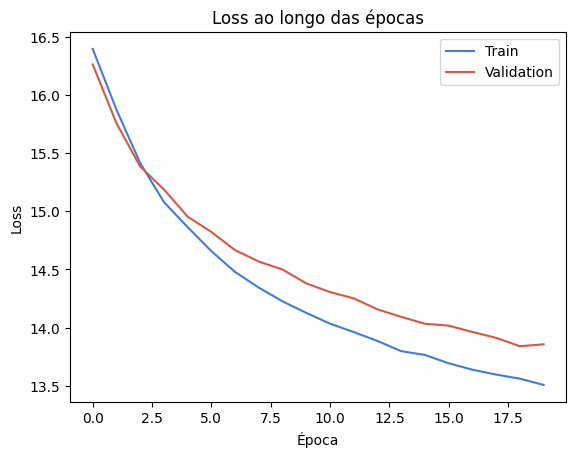

[Train dataset]:
Accuracy of the model: 0.2656
Accuracy for class: plane is 31.03 %
Accuracy for class: car   is 26.50 %
Accuracy for class: bird  is 22.70 %
Accuracy for class: cat   is 20.66 %
Accuracy for class: deer  is 24.18 %
Accuracy for class: dog   is 24.17 %
Accuracy for class: frog  is 25.07 %
Accuracy for class: horse is 25.26 %
Accuracy for class: ship  is 36.86 %
Accuracy for class: truck is 29.23 %
[Validation dataset]:
Accuracy of the model: 0.2470
Accuracy for class: plane is 28.60 %
Accuracy for class: car   is 24.26 %
Accuracy for class: bird  is 18.14 %
Accuracy for class: cat   is 15.86 %
Accuracy for class: deer  is 25.56 %
Accuracy for class: dog   is 23.08 %
Accuracy for class: frog  is 25.40 %
Accuracy for class: horse is 22.23 %
Accuracy for class: ship  is 34.57 %
Accuracy for class: truck is 29.30 %


In [ ]:
model = Model([3072, 420, 256, 10], [ReLU(), ReLU(), Softmax()], initialization_method="random")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)





























































100%|██████████| 60/60 [11:53<00:00, 11.89s/it]


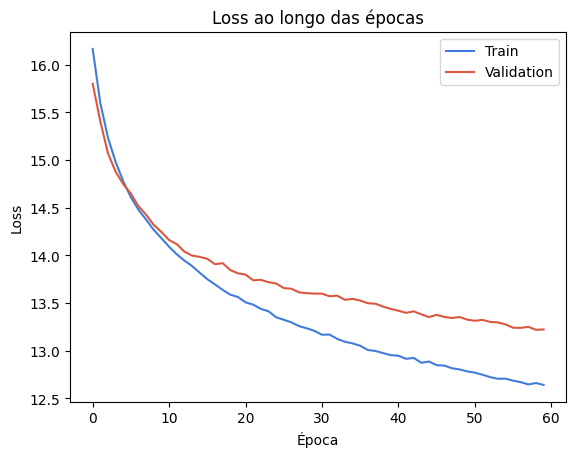

[Train dataset]:
Accuracy of the model: 0.3123
Accuracy for class: plane is 36.90 %
Accuracy for class: car   is 36.73 %
Accuracy for class: bird  is 24.37 %
Accuracy for class: cat   is 23.87 %
Accuracy for class: deer  is 27.11 %
Accuracy for class: dog   is 25.48 %
Accuracy for class: frog  is 32.39 %
Accuracy for class: horse is 30.79 %
Accuracy for class: ship  is 42.89 %
Accuracy for class: truck is 31.72 %
[Validation dataset]:
Accuracy of the model: 0.2812
Accuracy for class: plane is 32.23 %
Accuracy for class: car   is 34.42 %
Accuracy for class: bird  is 18.93 %
Accuracy for class: cat   is 21.59 %
Accuracy for class: deer  is 24.54 %
Accuracy for class: dog   is 23.37 %
Accuracy for class: frog  is 27.18 %
Accuracy for class: horse is 27.11 %
Accuracy for class: ship  is 40.90 %
Accuracy for class: truck is 30.90 %


In [ ]:
model = Model([3072, 420, 256, 10], [ReLU(), ReLU(), Softmax()], initialization_method="random")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(60, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)

> Quais são as conclusões? (1-2 parágrafos)


Escolhendo lr=1e-5 e 20 como número de épocas pudemos perceber que erro do treino se iguala ao erro de validação por volta da época 2. Após esse tangenciamento, pudemos perceber que ambos os erros diminuem e a diferença entre eles aumentam, sendo que ao chegar na época 20 essa diferença chega próximo de 0,5 e tem seu maior valor.

Além disso podemos destacar o valor alto para ambos os erros, tanto o relacionado ao conjunto de validação como também no de treino, atingindo em seus mínimos valores próximos a 14 e 13,5 respectivamente.

2. (2 pontos) Experimente outras duas técnicas de inicialização de peso e bias (He et al. Normalização e a outra que você implementou).





















100%|██████████| 20/20 [03:21<00:00, 10.07s/it]


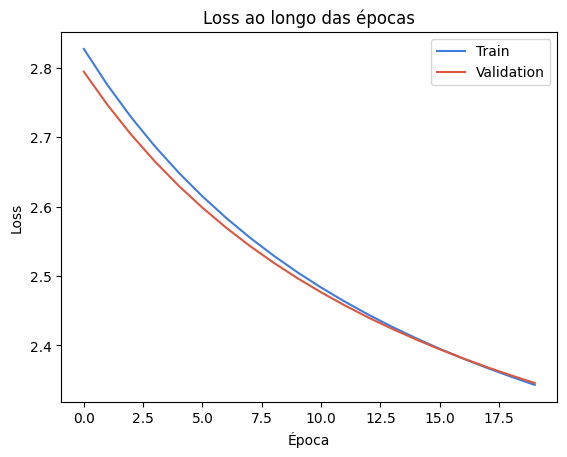

[Train dataset]:
Accuracy of the model: 0.1526
Accuracy for class: plane is 7.34 %
Accuracy for class: car   is 16.57 %
Accuracy for class: bird  is 7.38 %
Accuracy for class: cat   is 11.47 %
Accuracy for class: deer  is 32.73 %
Accuracy for class: dog   is 20.96 %
Accuracy for class: frog  is 10.30 %
Accuracy for class: horse is 5.83 %
Accuracy for class: ship  is 23.99 %
Accuracy for class: truck is 16.05 %
[Validation dataset]:
Accuracy of the model: 0.1530
Accuracy for class: plane is 6.65 %
Accuracy for class: car   is 15.78 %
Accuracy for class: bird  is 8.23 %
Accuracy for class: cat   is 11.85 %
Accuracy for class: deer  is 34.48 %
Accuracy for class: dog   is 19.53 %
Accuracy for class: frog  is 10.32 %
Accuracy for class: horse is 5.38 %
Accuracy for class: ship  is 25.93 %
Accuracy for class: truck is 14.90 %


In [ ]:
model = Model([3072, 420, 256, 10], [ReLU(), ReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)





























































100%|██████████| 60/60 [09:09<00:00,  9.15s/it]


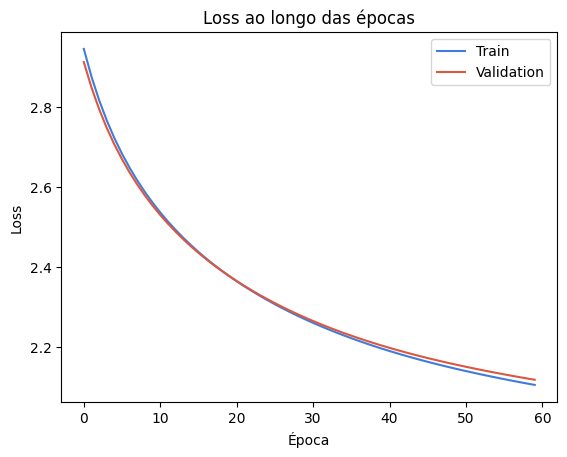

[Train dataset]:
Accuracy of the model: 0.2393
Accuracy for class: plane is 29.96 %
Accuracy for class: car   is 10.95 %
Accuracy for class: bird  is 13.71 %
Accuracy for class: cat   is 20.29 %
Accuracy for class: deer  is 21.84 %
Accuracy for class: dog   is 19.82 %
Accuracy for class: frog  is 25.07 %
Accuracy for class: horse is 16.73 %
Accuracy for class: ship  is 45.93 %
Accuracy for class: truck is 34.95 %
[Validation dataset]:
Accuracy of the model: 0.2357
Accuracy for class: plane is 28.40 %
Accuracy for class: car   is 12.03 %
Accuracy for class: bird  is 14.57 %
Accuracy for class: cat   is 19.58 %
Accuracy for class: deer  is 21.70 %
Accuracy for class: dog   is 20.61 %
Accuracy for class: frog  is 22.32 %
Accuracy for class: horse is 15.33 %
Accuracy for class: ship  is 48.14 %
Accuracy for class: truck is 33.00 %


In [ ]:
model = Model([3072, 420, 256, 10], [ReLU(), ReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(60, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)





















100%|██████████| 20/20 [02:17<00:00,  6.88s/it]


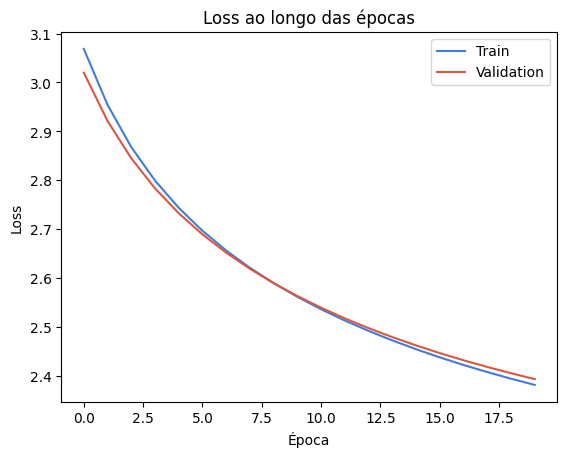

[Train dataset]:
Accuracy of the model: 0.1799
Accuracy for class: plane is 17.15 %
Accuracy for class: car   is 14.00 %
Accuracy for class: bird  is 12.17 %
Accuracy for class: cat   is 8.62 %
Accuracy for class: deer  is 14.77 %
Accuracy for class: dog   is 6.40 %
Accuracy for class: frog  is 25.57 %
Accuracy for class: horse is 19.59 %
Accuracy for class: ship  is 46.10 %
Accuracy for class: truck is 15.51 %
[Validation dataset]:
Accuracy of the model: 0.1780
Accuracy for class: plane is 18.03 %
Accuracy for class: car   is 11.83 %
Accuracy for class: bird  is 12.98 %
Accuracy for class: cat   is 7.83 %
Accuracy for class: deer  is 15.01 %
Accuracy for class: dog   is 7.00 %
Accuracy for class: frog  is 24.31 %
Accuracy for class: horse is 18.98 %
Accuracy for class: ship  is 46.03 %
Accuracy for class: truck is 16.00 %


In [ ]:
model = Model([3072, 420, 256, 10], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)





























































100%|██████████| 60/60 [06:47<00:00,  6.79s/it]


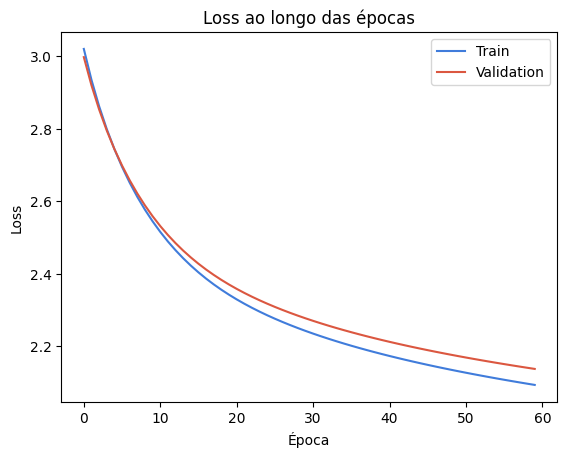

[Train dataset]:
Accuracy of the model: 0.2600
Accuracy for class: plane is 35.10 %
Accuracy for class: car   is 25.01 %
Accuracy for class: bird  is 15.52 %
Accuracy for class: cat   is 14.95 %
Accuracy for class: deer  is 24.08 %
Accuracy for class: dog   is 22.95 %
Accuracy for class: frog  is 26.43 %
Accuracy for class: horse is 19.06 %
Accuracy for class: ship  is 43.45 %
Accuracy for class: truck is 33.49 %
[Validation dataset]:
Accuracy of the model: 0.2488
Accuracy for class: plane is 32.02 %
Accuracy for class: car   is 24.26 %
Accuracy for class: bird  is 13.78 %
Accuracy for class: cat   is 13.45 %
Accuracy for class: deer  is 24.44 %
Accuracy for class: dog   is 20.91 %
Accuracy for class: frog  is 25.40 %
Accuracy for class: horse is 18.27 %
Accuracy for class: ship  is 44.22 %
Accuracy for class: truck is 32.00 %


In [ ]:
model = Model([3072, 420, 256, 10], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(60, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)

> Quais são as conclusões? Como as técnicas influenciam o desempenho dos modelos? (1-2 parágrafos)

Mantivemos o número de épocas e lr=1e-5 e alteramos as técnicas de inicialização. Pudemos perceber que tanto para a técnica "xavier" como para a "he" obtivemos a curva do erro de treinamento acima da curva do erro de validação, invertendo o cenário que tinhamos com a inicialização aleatória.
Pode-se perceber também que as curvas estão mais próximas também para ambos métodos de inicialização, sendo que no grafico associado à inicialização "xavier" percebe-se que a diferença entre erros de validação e treino volta a crescer depois da época 15, aproximadamente, enquanto no gráfico do método "he" as curvas convergem até a época visualizada.

Devemos também destacar o valor aproximadamente 7x menor para os erros encontrados em comparação com o método de inicialização alatória, atingindo valores próximos a 2,4

3. (1 ponto) Escolha a técnica de inicialização de peso e bias que resultou no melhor desempenho e tente a outra função de ativação que você implementou.





















100%|██████████| 20/20 [02:46<00:00,  8.32s/it]
Exception ignored in: <function tqdm.__del__ at 0x1079098a0>
Traceback (most recent call last):
  File "/Users/paulopacitti/.pyenv/versions/3.11.2/lib/python3.11/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/Users/paulopacitti/.pyenv/versions/3.11.2/lib/python3.11/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x1079098a0>
Traceback (most recent call last):
  File "/Users/paulopacitti/.pyenv/versions/3.11.2/lib/python3.11/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/Users/paulopacitti/.pyenv/versions/3.11.2/lib/python3.11/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object ha

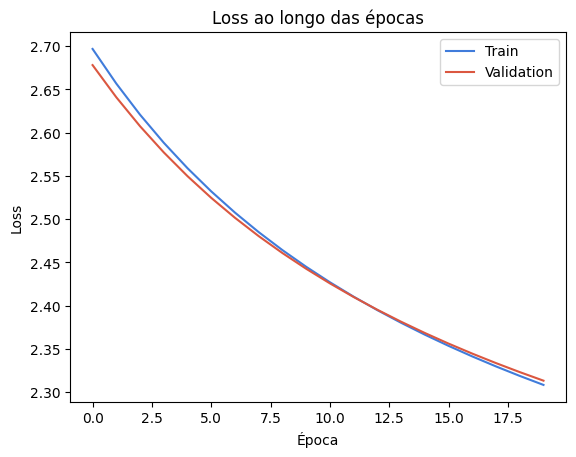

[Train dataset]:
Accuracy of the model: 0.1631
Accuracy for class: plane is 29.26 %
Accuracy for class: car   is 10.03 %
Accuracy for class: bird  is 2.88 %
Accuracy for class: cat   is 3.75 %
Accuracy for class: deer  is 16.55 %
Accuracy for class: dog   is 25.21 %
Accuracy for class: frog  is 19.91 %
Accuracy for class: horse is 9.03 %
Accuracy for class: ship  is 25.65 %
Accuracy for class: truck is 20.81 %
[Validation dataset]:
Accuracy of the model: 0.1631
Accuracy for class: plane is 29.10 %
Accuracy for class: car   is 10.26 %
Accuracy for class: bird  is 1.98 %
Accuracy for class: cat   is 3.71 %
Accuracy for class: deer  is 17.24 %
Accuracy for class: dog   is 23.87 %
Accuracy for class: frog  is 19.84 %
Accuracy for class: horse is 10.36 %
Accuracy for class: ship  is 25.73 %
Accuracy for class: truck is 21.00 %


In [ ]:
model = Model([3072, 420, 256, 10], [LeakyReLU(), LeakyReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)

> Quais são as conclusões? Faz alguma diferença nos resultados? (1-2 parágrafos)

Houve diferença no resultado. Substituindo o uso da função ReLU pela LeakyReLU e um número maior de épocas conseguimos atingir um minimo próximo de 2,1 para o erro, com o método de inicialização "xavier".

4. (3 pontos) Explorar diferentes arquiteturas de rede, variando o número de camadas e o número de neurônios em cada camada. É um experimento empírico.

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [04:40<00:00, 14.01s/it]


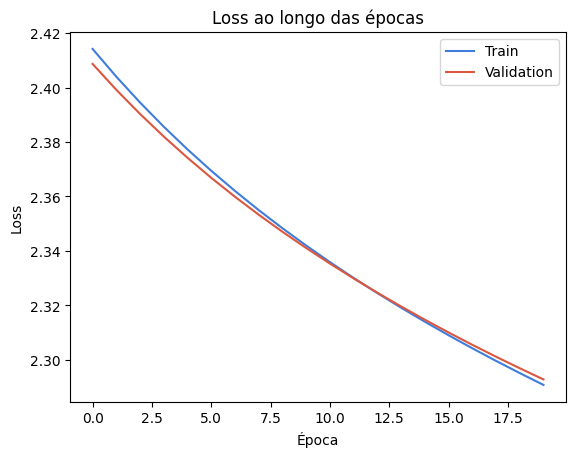

[Train dataset]:
Accuracy of the model: 0.1402
Accuracy for class: plane is 3.30 %
Accuracy for class: car   is 7.79 %
Accuracy for class: bird  is 16.39 %
Accuracy for class: cat   is 6.10 %
Accuracy for class: deer  is 11.02 %
Accuracy for class: dog   is 19.48 %
Accuracy for class: frog  is 26.37 %
Accuracy for class: horse is 1.13 %
Accuracy for class: ship  is 48.25 %
Accuracy for class: truck is 0.37 %
[Validation dataset]:
Accuracy of the model: 0.1394
Accuracy for class: plane is 3.22 %
Accuracy for class: car   is 7.50 %
Accuracy for class: bird  is 13.78 %
Accuracy for class: cat   is 5.42 %
Accuracy for class: deer  is 12.37 %
Accuracy for class: dog   is 19.92 %
Accuracy for class: frog  is 27.08 %
Accuracy for class: horse is 0.81 %
Accuracy for class: ship  is 48.74 %
Accuracy for class: truck is 0.60 %


In [ ]:
model = Model([3072, 880, 280, 500, 80, 10], [LeakyReLU(), ReLU(), LeakyReLU(), ReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)

  0%|          | 0/20 [00:00<?, ?it/s]

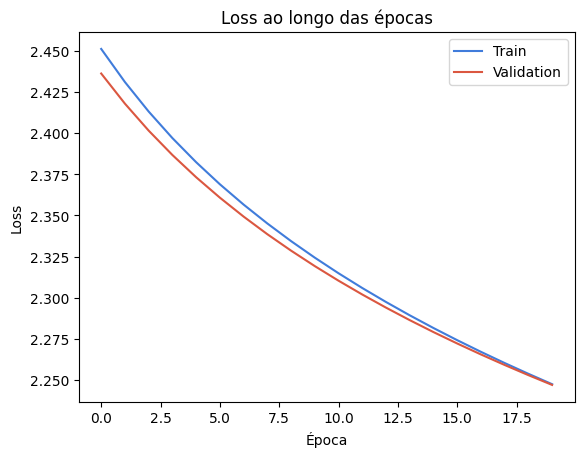

Acurácia de treino 

Accuracy of the model: 0.1595
Accuracy for class: plane is 23.5 %
Accuracy for class: car   is 10.2 %
Accuracy for class: bird  is 13.9 %
Accuracy for class: cat   is 16.5 %
Accuracy for class: deer  is 11.9 %
Accuracy for class: dog   is 9.5 %
Accuracy for class: frog  is 14.0 %
Accuracy for class: horse is 17.1 %
Accuracy for class: ship  is 39.1 %
Accuracy for class: truck is 3.8 %
Acurácia de validação 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Accuracy of the model: 0.1637
Accuracy for class: plane is 23.1 %
Accuracy for class: car   is 9.4 %
Accuracy for class: bird  is 12.0 %
Accuracy for class: cat   is 19.9 %
Accuracy for class: deer  is 12.7 %
Accuracy for class: dog   is 9.3 %
Accuracy for class: frog  is 15.1 %
Accuracy for class: horse is 18.3 %
Accuracy for class: ship  is 39.3 %
Accuracy for class: truck is 3.4 %


In [ ]:
model = Model([3072, 1000, 680, 80, 10], [LeakyReLU(), ReLU(), LeakyReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)
train_accuracy = trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [05:26<00:00, 16.32s/it]


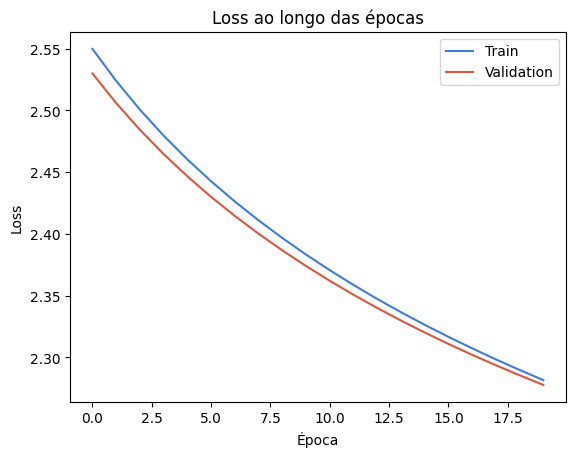

[Train dataset]:
Accuracy of the model: 0.1615
Accuracy for class: plane is 15.58 %
Accuracy for class: car   is 4.98 %
Accuracy for class: bird  is 6.37 %
Accuracy for class: cat   is 4.51 %
Accuracy for class: deer  is 0.99 %
Accuracy for class: dog   is 14.02 %
Accuracy for class: frog  is 35.38 %
Accuracy for class: horse is 14.66 %
Accuracy for class: ship  is 35.18 %
Accuracy for class: truck is 29.83 %
[Validation dataset]:
Accuracy of the model: 0.1616
Accuracy for class: plane is 15.21 %
Accuracy for class: car   is 3.16 %
Accuracy for class: bird  is 6.54 %
Accuracy for class: cat   is 4.22 %
Accuracy for class: deer  is 1.22 %
Accuracy for class: dog   is 15.68 %
Accuracy for class: frog  is 35.62 %
Accuracy for class: horse is 17.56 %
Accuracy for class: ship  is 35.98 %
Accuracy for class: truck is 26.40 %


In [ ]:
model = Model([3072, 1000, 680, 80, 10], [LeakyReLU(), ReLU(), LeakyReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)

  0%|          | 0/20 [00:00<?, ?it/s]

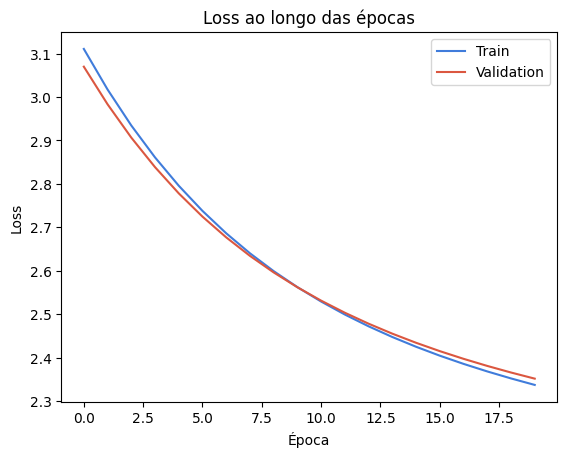

Acurácia de treino 

Accuracy of the model: 0.1890
Accuracy for class: plane is 24.3 %
Accuracy for class: car   is 19.7 %
Accuracy for class: bird  is 20.1 %
Accuracy for class: cat   is 6.3 %
Accuracy for class: deer  is 23.7 %
Accuracy for class: dog   is 11.4 %
Accuracy for class: frog  is 16.4 %
Accuracy for class: horse is 11.1 %
Accuracy for class: ship  is 28.2 %
Accuracy for class: truck is 27.5 %
Acurácia de validação 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Accuracy of the model: 0.1881
Accuracy for class: plane is 23.1 %
Accuracy for class: car   is 16.5 %
Accuracy for class: bird  is 22.4 %
Accuracy for class: cat   is 6.9 %
Accuracy for class: deer  is 23.1 %
Accuracy for class: dog   is 12.0 %
Accuracy for class: frog  is 16.5 %
Accuracy for class: horse is 11.3 %
Accuracy for class: ship  is 29.1 %
Accuracy for class: truck is 27.9 %


In [ ]:
model = Model([3072, 666, 10], [ReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)
train_accuracy = trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:08<00:00,  9.41s/it]


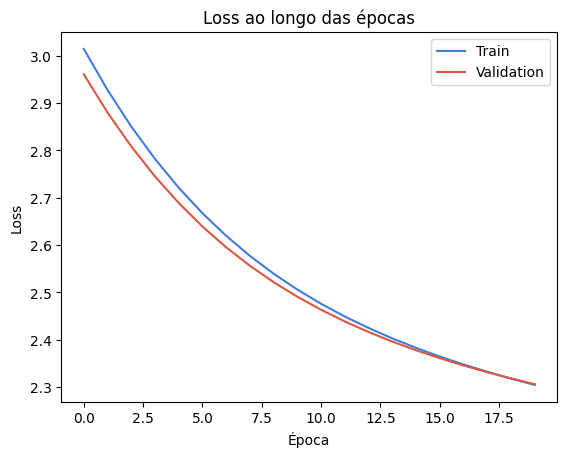

[Train dataset]:
Accuracy of the model: 0.1977
Accuracy for class: plane is 35.50 %
Accuracy for class: car   is 17.15 %
Accuracy for class: bird  is 13.88 %
Accuracy for class: cat   is 18.07 %
Accuracy for class: deer  is 13.42 %
Accuracy for class: dog   is 9.40 %
Accuracy for class: frog  is 24.18 %
Accuracy for class: horse is 7.86 %
Accuracy for class: ship  is 35.37 %
Accuracy for class: truck is 22.90 %
[Validation dataset]:
Accuracy of the model: 0.1979
Accuracy for class: plane is 35.65 %
Accuracy for class: car   is 16.27 %
Accuracy for class: bird  is 11.89 %
Accuracy for class: cat   is 18.47 %
Accuracy for class: deer  is 12.07 %
Accuracy for class: dog   is 9.27 %
Accuracy for class: frog  is 25.30 %
Accuracy for class: horse is 10.36 %
Accuracy for class: ship  is 37.99 %
Accuracy for class: truck is 20.60 %


In [ ]:
model = Model([3072, 666, 10], [LeakyReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)

  0%|          | 0/20 [00:00<?, ?it/s]

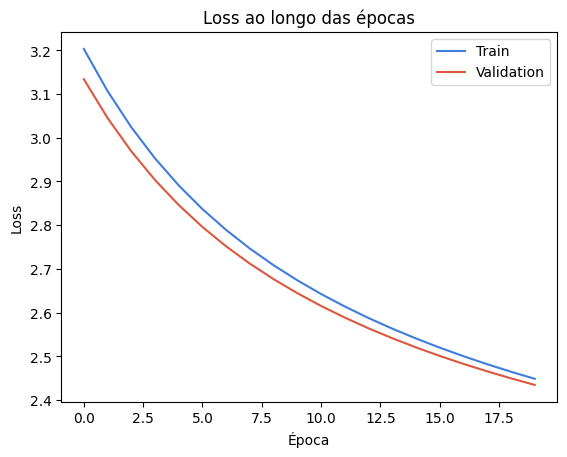

Acurácia de treino 

Accuracy of the model: 0.1857
Accuracy for class: plane is 10.8 %
Accuracy for class: car   is 10.5 %
Accuracy for class: bird  is 8.8 %
Accuracy for class: cat   is 10.3 %
Accuracy for class: deer  is 20.4 %
Accuracy for class: dog   is 13.2 %
Accuracy for class: frog  is 23.5 %
Accuracy for class: horse is 13.8 %
Accuracy for class: ship  is 42.1 %
Accuracy for class: truck is 32.1 %
Acurácia de validação 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Accuracy of the model: 0.1891
Accuracy for class: plane is 10.4 %
Accuracy for class: car   is 10.8 %
Accuracy for class: bird  is 7.0 %
Accuracy for class: cat   is 11.3 %
Accuracy for class: deer  is 20.6 %
Accuracy for class: dog   is 13.9 %
Accuracy for class: frog  is 24.6 %
Accuracy for class: horse is 13.8 %
Accuracy for class: ship  is 42.4 %
Accuracy for class: truck is 31.2 %


In [ ]:
model = Model([3072, 10], [Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)
train_accuracy = trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)


> Quais são as conclusões? Como o número de camadas afeta o desempenho dos modelos? (2-4 parágrafos)

Pudemos perceber alterações no desempenho dos modelos, dentre elas:
Dado a regra para o framework de que o vetor de ativações sempre tem que ser menor em 1 unidade em relação ao vetor de topologia da rede, experimentos que não seguiram tal determinação apresentaram erro crescente. Sabe-se também que poderia-se alterar arbitrariamente no interior na rede, mas a Softmax seria obrigatória no final pois o problema é de classificação. Apesar disso, também testamos exploratóriamente o que aconteceria nesse cenarios que percebemos os erros aumentavam e divergiam.

Dos resultados válidos,

5. (2 pontos) Escolha a melhor arquitetura de rede e treine seu modelo usando o otimizador que você escolheu implementar.

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [09:25<00:00, 28.29s/it]


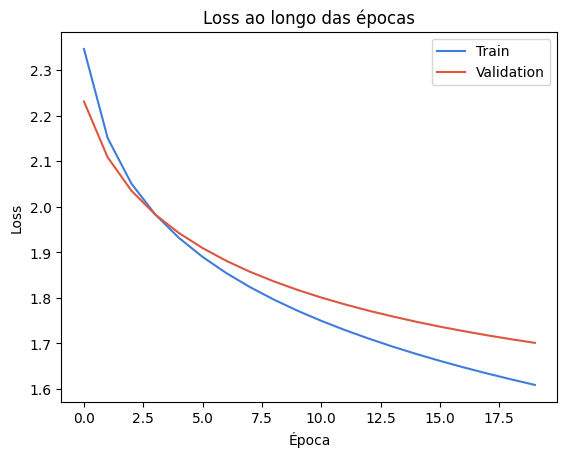

Accuracy of the model: 0.4471
Accuracy for class: plane is 47.01 %
Accuracy for class: car   is 51.17 %
Accuracy for class: bird  is 30.47 %
Accuracy for class: cat   is 32.33 %
Accuracy for class: deer  is 36.81 %
Accuracy for class: dog   is 38.52 %
Accuracy for class: frog  is 50.38 %
Accuracy for class: horse is 46.85 %
Accuracy for class: ship  is 61.85 %
Accuracy for class: truck is 51.70 %
[Train dataset]:
Accuracy of the model: 0.4471
Accuracy for class: plane is 47.01 %
Accuracy for class: car   is 51.17 %
Accuracy for class: bird  is 30.47 %
Accuracy for class: cat   is 32.33 %
Accuracy for class: deer  is 36.81 %
Accuracy for class: dog   is 38.52 %
Accuracy for class: frog  is 50.38 %
Accuracy for class: horse is 46.85 %
Accuracy for class: ship  is 61.85 %
Accuracy for class: truck is 51.70 %
[Validation dataset]:
Accuracy of the model: 0.3939
Accuracy for class: plane is 41.89 %
Accuracy for class: car   is 46.15 %
Accuracy for class: bird  is 23.19 %
Accuracy for class: 

In [ ]:
model = Model([3072, 1000, 680, 80, 10], [LeakyReLU(), ReLU(), LeakyReLU(), Softmax()], initialization_method="xavier")
opt = AdamOptmizer(model, lr=1e-6)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)
train_accuracy = trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)

  0%|          | 0/10 [00:00<?, ?it/s]

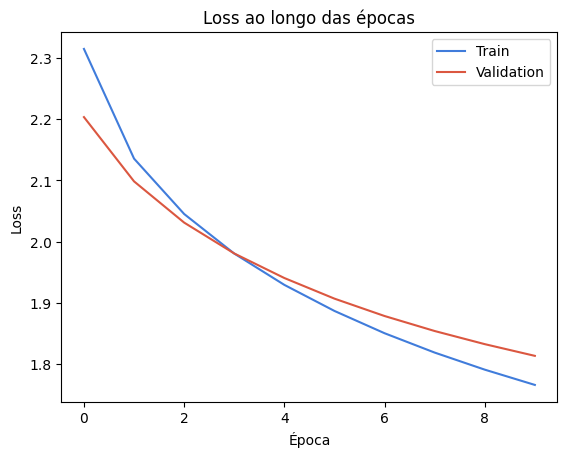

Acurácia de treino 

Accuracy of the model: 0.3862
Accuracy for class: plane is 41.6 %
Accuracy for class: car   is 42.7 %
Accuracy for class: bird  is 28.7 %
Accuracy for class: cat   is 26.0 %
Accuracy for class: deer  is 29.2 %
Accuracy for class: dog   is 30.4 %
Accuracy for class: frog  is 41.7 %
Accuracy for class: horse is 38.5 %
Accuracy for class: ship  is 57.1 %
Accuracy for class: truck is 50.7 %
Acurácia de validação 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Accuracy of the model: 0.3607
Accuracy for class: plane is 38.5 %
Accuracy for class: car   is 38.1 %
Accuracy for class: bird  is 24.6 %
Accuracy for class: cat   is 22.2 %
Accuracy for class: deer  is 27.5 %
Accuracy for class: dog   is 26.6 %
Accuracy for class: frog  is 40.4 %
Accuracy for class: horse is 35.3 %
Accuracy for class: ship  is 58.6 %
Accuracy for class: truck is 46.6 %


In [ ]:
model = Model([3072, 1000, 680, 80, 10], [LeakyReLU(), ReLU(), LeakyReLU(), Softmax()], initialization_method="xavier")
opt = AdamOptmizer(model, lr=1e-6)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(10, train_loader, val_loader)
plot_history(history)
train_accuracy = trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [02:20<00:00, 28.01s/it]


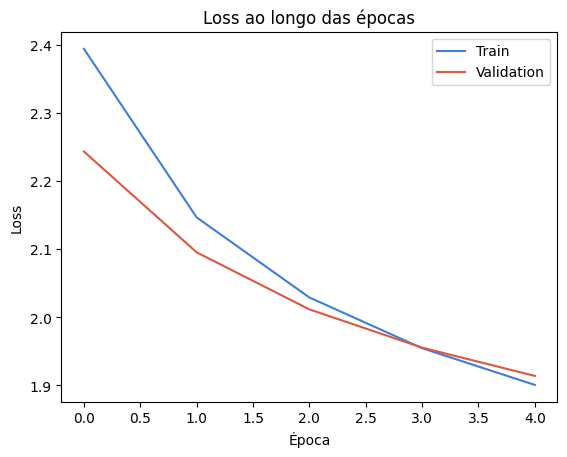

[Train dataset]:
Accuracy of the model: 0.3297
Accuracy for class: plane is 34.43 %
Accuracy for class: car   is 30.13 %
Accuracy for class: bird  is 17.13 %
Accuracy for class: cat   is 25.23 %
Accuracy for class: deer  is 30.56 %
Accuracy for class: dog   is 28.92 %
Accuracy for class: frog  is 33.65 %
Accuracy for class: horse is 32.96 %
Accuracy for class: ship  is 55.36 %
Accuracy for class: truck is 41.34 %
[Validation dataset]:
Accuracy of the model: 0.3182
Accuracy for class: plane is 34.94 %
Accuracy for class: car   is 30.57 %
Accuracy for class: bird  is 14.37 %
Accuracy for class: cat   is 22.09 %
Accuracy for class: deer  is 31.24 %
Accuracy for class: dog   is 25.05 %
Accuracy for class: frog  is 30.46 %
Accuracy for class: horse is 32.28 %
Accuracy for class: ship  is 58.89 %
Accuracy for class: truck is 38.30 %


In [ ]:
model = Model([3072, 1000, 680, 80, 10], [LeakyReLU(), ReLU(), LeakyReLU(), Softmax()], initialization_method="xavier")
opt = AdamOptmizer(model, lr=1e-6)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(5, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [11:05<00:00, 33.29s/it]


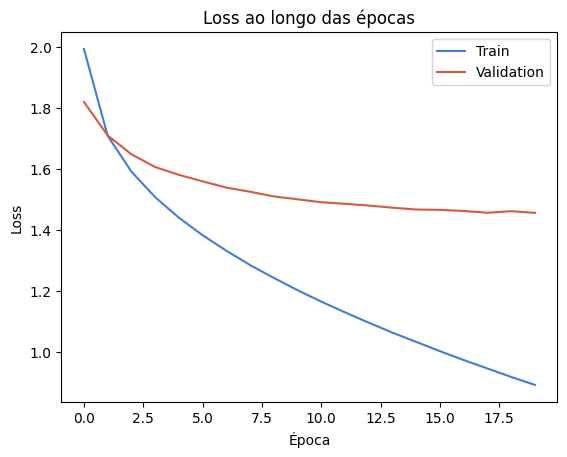

[Train dataset]:
Accuracy of the model: 0.7548
Accuracy for class: plane is 74.64 %
Accuracy for class: car   is 79.63 %
Accuracy for class: bird  is 70.47 %
Accuracy for class: cat   is 68.57 %
Accuracy for class: deer  is 68.49 %
Accuracy for class: dog   is 72.80 %
Accuracy for class: frog  is 78.07 %
Accuracy for class: horse is 79.17 %
Accuracy for class: ship  is 83.52 %
Accuracy for class: truck is 79.39 %
[Validation dataset]:
Accuracy of the model: 0.4977
Accuracy for class: plane is 51.66 %
Accuracy for class: car   is 57.10 %
Accuracy for class: bird  is 35.48 %
Accuracy for class: cat   is 34.14 %
Accuracy for class: deer  is 41.78 %
Accuracy for class: dog   is 38.56 %
Accuracy for class: frog  is 54.96 %
Accuracy for class: horse is 56.95 %
Accuracy for class: ship  is 72.16 %
Accuracy for class: truck is 54.90 %


In [ ]:
model = Model([3072, 1000, 680, 80, 10], [LeakyReLU(), ReLU(), LeakyReLU(), Softmax()], initialization_method="xavier")
opt = AdamOptmizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)

print("[Train dataset]:")
trainer.accuracy(train_loader)
trainer.accuracy_for_class(train_loader, classes)

print("[Validation dataset]:")
trainer.accuracy(val_loader)
trainer.accuracy_for_class(val_loader, classes)


> Quais são as conclusões? A mudança de otimizador impacta de alguma forma a curva de perdas ao longo das épocas? (1-2 parágrafos)


6. (1 ponto) Escolha seu **melhor modelo**, faça previsões para o conjunto de teste.

> Quais são as conclusões? (1-2 parágrafos)